## Investigating edge features for high AUROC scores

My model is currently performing better than the other methods on average. My goal here is the determine which edges are performing better to determine which variables are improving the AUROC scores.

### Load the basic trained model

The best model settings for AUROC are: 
- **Model Size:** 192
- **Number of Metacells:** 10k
- **Number of Attention Heads:** 8
- **Number of Attention Layers:** 3

In [190]:
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

import dev.auroc_testing as auroc_testing

EXPERIMENT_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear")
GROUND_TRUTH_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/ground_truth_files")
FIG_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/figure_pdfs")

base_model_dir = EXPERIMENT_DIR / "model_training_192_10k_metacells"

model_file = base_model_dir / "trained_model.pt"
training_log_file = base_model_dir / "training_log.csv"

tf_ko_count_file = base_model_dir / "tf_tg_fullmodel_knockout_count.npy"
tf_ko_score_file = base_model_dir / "tf_tg_fullmodel_knockout.npy"

tf_grad_attrib_file = base_model_dir / "tf_tg_grad_attribution.npy"

tf_tg_vocab_file = base_model_dir / "tf_tg_vocab_id2name.pt"

### Load experiment info

In [191]:
import importlib

importlib.reload(auroc_testing)

<module 'dev.auroc_testing' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/auroc_testing.py'>

In [192]:
def load_gradient_attribution_matrix(selected_experiment_dir, tf_names, tg_names):
    # --- load gradient attribution matrix ---
    grad = np.load(selected_experiment_dir / "tf_tg_grad_attribution.npy")  # shape [T, G]
    assert grad.shape == (len(tf_names), len(tg_names))

    # Optional: handle NaNs
    grad = np.nan_to_num(grad, nan=0.0)

    # Use absolute gradient magnitude as importance
    grad_abs = np.abs(grad)

    # Row-wise z-score per TF (ignore NaNs if you keep them)
    row_mean = grad_abs.mean(axis=1, keepdims=True)
    row_std  = grad_abs.std(axis=1, keepdims=True) + 1e-6
    grad_z = (grad_abs - row_mean) / row_std   # [T, G]

    # Build long-form dataframe
    T, G = grad_z.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    gradient_attrib_df = pd.DataFrame({
        "Source": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.array(tg_names, dtype=object)[tg_idx.ravel()],
        "Score": grad_z.ravel(),
    })
    gradient_attrib_df["Source"] = gradient_attrib_df["Source"].astype(str).str.upper()
    gradient_attrib_df["Target"] = gradient_attrib_df["Target"].astype(str).str.upper()
    
    return gradient_attrib_df

In [193]:
tf_names, tg_names = auroc_testing.load_vocab(base_model_dir)
gradient_attrib_df = load_gradient_attribution_matrix(base_model_dir, tf_names, tg_names)
tf_ko_df = auroc_testing.load_tf_knockout_scores(base_model_dir, tf_names, tg_names)

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/auroc_testing.py:1263: RuntimeWarning: Mean of empty slice
  row_mean = np.nanmean(effect_pos, axis=1, keepdims=True)
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [194]:
print(gradient_attrib_df.head())

          Source         Target     Score
0  2810021J22RIK  0610005C13RIK -0.331956
1  2810021J22RIK  0610009E02RIK -0.460897
2  2810021J22RIK  0610030E20RIK -0.471392
3  2810021J22RIK  1110002J07RIK -0.496627
4  2810021J22RIK  1110019D14RIK  0.038720


### Ground Truth Files

In [195]:
ground_truth_file_dict = {
    "ChIP-Atlas": GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv",
    "RN111": GROUND_TRUTH_DIR / "RN111.tsv",
    "RN112": GROUND_TRUTH_DIR / "RN112.tsv",
    "RN114": GROUND_TRUTH_DIR / "RN114.tsv",
    "RN115": GROUND_TRUTH_DIR / "RN115.tsv",
    "RN116": GROUND_TRUTH_DIR / "RN116.tsv",
}

gt_edges_dict = {}
gt_tf_dict = {}
gt_tg_dict = {}
ground_truth_df_dict = {}

# Loop through each ground truth dataset
for i, (gt_name, ground_truth_file) in enumerate(ground_truth_file_dict.items(), start=1):
    print(f"Loading {gt_name} ({i}/{len(ground_truth_file_dict)})")

    gt_analysis_dir = base_model_dir / f"{gt_name}_analysis"
    os.makedirs(gt_analysis_dir, exist_ok=True)

    # --- Ground truth & sets ---
    ground_truth_df = auroc_testing.load_ground_truth(ground_truth_file)
    
    ground_truth_df_dict[gt_name] = ground_truth_df

    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names)
        & ground_truth_df["Target"].isin(tg_names)
    ]
    
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs   = set(chip_valid["Source"])
    gt_tgs   = set(chip_valid["Target"])
    
    gt_edges_dict[gt_name] = gt_edges
    gt_tf_dict[gt_name] = gt_tfs
    gt_tg_dict[gt_name] = gt_tgs

Loading ChIP-Atlas (1/6)
Loading RN111 (2/6)
Loading RN112 (3/6)
Loading RN114 (4/6)
Loading RN115 (5/6)
Loading RN116 (6/6)


### Per Ground Truth AUROC and AUPRC

Computing metrics for ChIP-Atlas...
Computing metrics for RN111...
Computing metrics for RN112...
Computing metrics for RN114...
Computing metrics for RN115...
Computing metrics for RN116...

=== Method Ranking ===
                      mean_auroc  std_auroc  mean_auprc  std_auprc  n_gt
name                                                                    
Gradient Attribution    0.536336   0.021226    0.532651   0.020841     6
TF Knockout             0.528736   0.022348    0.526486   0.018922     6


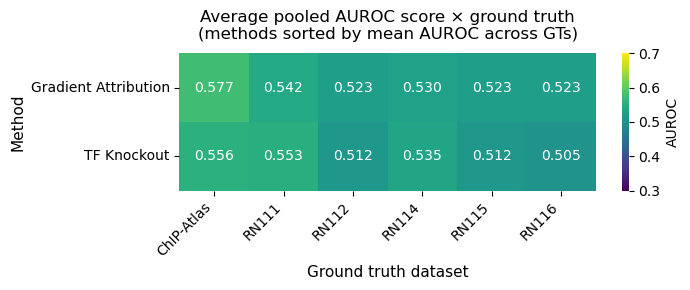

In [196]:
method_dict_base = {
    "Gradient Attribution": gradient_attrib_df,  # Original, unfiltered
    "TF Knockout": tf_ko_df                       # Original, unfiltered
}

all_method_results = []

# Loop through each ground truth dataset
for gt_name, ground_truth_df in ground_truth_df_dict.items():
    print(f"Computing metrics for {gt_name}...")
    
    # Get TFs and TGs that are actually in your model
    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names) &
        ground_truth_df["Target"].isin(tg_names)
    ]
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs = set(chip_valid["Source"])
    gt_tgs = set(chip_valid["Target"])
    
    # Filter and label for THIS specific ground truth
    for method_name, method_df in method_dict_base.items():
        # Filter to THIS GT's gene set
        filtered_df = auroc_testing.filter_df_to_gene_set(
            method_df.copy(), 
            gt_tfs,  # THIS GT's TFs only
            gt_tgs   # THIS GT's TGs only
        )
        
        # Label with THIS GT's edges
        labeled_df = auroc_testing.label_edges(filtered_df, gt_edges)
        
        # labeled_df["Score"] = labeled_df["Score"].abs()
        
        # Compute AUROC/AUPRC
        res = auroc_testing.compute_curves(
            labeled_df,
            score_col="Score",
            label_col="is_gt",  # Standard label column
            balance=True,
            name=method_name,
        )
        
        if res is not None:
            res["gt_name"] = gt_name
            res["sample"] = "POOLED"
            all_method_results.append(res)

# Convert to DataFrame
df_results = pd.DataFrame(all_method_results)

# Compute method ranking
method_rank = (
    df_results
    .groupby("name")
    .agg(
        mean_auroc=("auroc", "mean"),
        std_auroc=("auroc", "std"),
        mean_auprc=("auprc", "mean"),
        std_auprc=("auprc", "std"),
        n_gt=("gt_name", "nunique"),
    )
    .sort_values("mean_auroc", ascending=False)
)

print("\n=== Method Ranking ===")
print(method_rank)

auroc_heat_fig = auroc_testing.plot_method_gt_heatmap(df_results, metric="auroc")
auroc_heat_fig.show()

### Per-TF metrics

#### Calculate AUROC per TF

In [197]:
method_dict_base = {
    "Gradient Attribution": gradient_attrib_df,
    "TF Knockout": tf_ko_df
}

per_tf_all_results = []

# Loop through each ground truth dataset
for gt_name, ground_truth_df in ground_truth_df_dict.items():
    print(f"Computing per-TF metrics for {gt_name}...")

    
    # Get TFs and TGs that are actually in your model
    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names) &
        ground_truth_df["Target"].isin(tg_names)
    ]
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs = set(chip_valid["Source"])
    gt_tgs = set(chip_valid["Target"])
    
    # Compute per-TF metrics for each method
    for method_name, method_df in method_dict_base.items():
        # Filter to THIS GT's gene set
        filtered_df = auroc_testing.filter_df_to_gene_set(
            method_df.copy(), 
            gt_tfs,
            gt_tgs
        )
        
        # Label with THIS GT's edges
        labeled_df = auroc_testing.label_edges(filtered_df, gt_edges)
        
        # Compute per-TF metrics
        per_tf_df = auroc_testing.compute_per_tf_metrics(
            labeled_df,
            score_col="Score",
            label_col="is_gt",
            tf_col="Source",
            min_edges=10,
            min_pos=1,
            balance=True,
        )
        
        if per_tf_df.empty:
            print(f"  No valid TFs for {method_name} in {gt_name}")
            continue
        
        # Add metadata
        per_tf_df["method"] = method_name
        per_tf_df["gt_name"] = gt_name
        
        per_tf_all_results.append(per_tf_df)
        print(f"  {method_name}: {len(per_tf_df)} TFs")

# Concatenate all results
per_tf_metrics = pd.concat(per_tf_all_results, ignore_index=True)

print(f"\n=== Per-TF Metrics Summary ===")
print(f"Total rows: {len(per_tf_metrics)}")
print(f"Unique TFs: {per_tf_metrics['tf'].nunique()}")
print(f"Methods: {per_tf_metrics['method'].unique()}")
print(f"Ground truths: {per_tf_metrics['gt_name'].unique()}")

# Save detailed per-TF metrics
per_tf_metrics.to_csv("per_tf_auroc_auprc_detailed.csv", index=False)
print("\nSaved: per_tf_auroc_auprc_detailed.csv")

Computing per-TF metrics for ChIP-Atlas...
  Gradient Attribution: 58 TFs
  TF Knockout: 58 TFs
Computing per-TF metrics for RN111...
  Gradient Attribution: 34 TFs
  TF Knockout: 34 TFs
Computing per-TF metrics for RN112...
  Gradient Attribution: 23 TFs
  TF Knockout: 23 TFs
Computing per-TF metrics for RN114...
  Gradient Attribution: 18 TFs
  TF Knockout: 18 TFs
Computing per-TF metrics for RN115...
  Gradient Attribution: 23 TFs
  TF Knockout: 23 TFs
Computing per-TF metrics for RN116...
  Gradient Attribution: 12 TFs
  TF Knockout: 12 TFs

=== Per-TF Metrics Summary ===
Total rows: 336
Unique TFs: 88
Methods: ['Gradient Attribution' 'TF Knockout']
Ground truths: ['ChIP-Atlas' 'RN111' 'RN112' 'RN114' 'RN115' 'RN116']

Saved: per_tf_auroc_auprc_detailed.csv


#### Macro vs Micro AUROC

In [198]:
df = per_tf_metrics.query("method == 'Gradient Attribution'")  # or any method

# Macro per-TF AUROC (averaged across TFs)
macro_auroc = df.groupby("tf")["auroc"].mean().mean()

# Micro per-TF AUROC (weighted by num edges per TF)
micro_auroc = (
    df.groupby("tf")
      .apply(lambda g: g["auroc"].mean() * g["n_edges"].sum())
      .sum() / df["n_edges"].sum()
)

tf_stats = (
    df.groupby("tf")
      .agg(
          mean_auroc=("auroc", "mean"),
          n_edges=("n_edges", "sum"),
      )
)

# TF weight in micro AUROC
tf_stats["weight"] = tf_stats["n_edges"] / tf_stats["n_edges"].sum()

# Contribution of each TF to the micro AUROC
tf_stats["micro_contrib"] = tf_stats["mean_auroc"] * tf_stats["weight"]

print("Macro AUROC:", macro_auroc)
print("Micro AUROC:", micro_auroc)

# TFs with lots of edges
print(tf_stats.sort_values("n_edges", ascending=False).head(10))

# Worst TFs by AUROC
print(tf_stats.sort_values("mean_auroc").head(10))

# Biggest contributors to micro AUROC (good or bad)
print(tf_stats.sort_values("micro_contrib", ascending=False).head(10))
print(tf_stats.sort_values("micro_contrib").head(10))


Macro AUROC: 0.5783816757909954
Micro AUROC: 0.5716241556120281
        mean_auroc  n_edges    weight  micro_contrib
tf                                                  
SMAD1     0.454942    27707  0.030909       0.014062
SOX2      0.549739    27707  0.030909       0.016992
KLF5      0.614601    27707  0.030909       0.018997
MYC       0.534730    27707  0.030909       0.016528
OTX2      0.570487    21526  0.024014       0.013699
ESRRB     0.514402    21020  0.023449       0.012062
POU5F1    0.578360    21020  0.023449       0.013562
NANOG     0.578029    21020  0.023449       0.013554
KLF4      0.505711    21020  0.023449       0.011858
TBX3      0.583000    21020  0.023449       0.013671
       mean_auroc  n_edges    weight  micro_contrib
tf                                                 
ETV2     0.333333     6041  0.006739       0.002246
MBD2     0.375000     6041  0.006739       0.002527
JUN      0.421280     6041  0.006739       0.002839
ELF1     0.431953     8798  0.009815    

/tmp/ipykernel_1379925/392402452.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


#### Micro AUROC by TF cutoff threshold

In [199]:
def recompute_micro(df_sub):
    return (
        df_sub.groupby("tf")
              .apply(lambda g: g["auroc"].mean() * g["n_edges"].sum())
              .sum() / df_sub["n_edges"].sum()
    )

for frac in [0.01, 0.05, 0.1]:
    cutoff = tf_stats["mean_auroc"].quantile(frac)
    keep_tfs = tf_stats[tf_stats["mean_auroc"] > cutoff].index
    df_sub = df[df["tf"].isin(keep_tfs)]
    micro_sub = recompute_micro(df_sub)
    print(f"Drop worst {int(frac*100)}% TFs -> micro AUROC = {micro_sub:.3f}")


Drop worst 1% TFs -> micro AUROC = 0.573
Drop worst 5% TFs -> micro AUROC = 0.581
Drop worst 10% TFs -> micro AUROC = 0.586


/tmp/ipykernel_1379925/1992507766.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sub.groupby("tf")
/tmp/ipykernel_1379925/1992507766.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sub.groupby("tf")
/tmp/ipykernel_1379925/1992507766.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be ex

In [200]:
# Worst 5 TFs by mean AUROC
worst_tfs = tf_stats.sort_values("mean_auroc").head(5).index.tolist()
print("Worst TFs:", worst_tfs)

# Also explicitly include SMAD1 if it's not already
if "SMAD1" not in worst_tfs:
    worst_tfs.append("SMAD1")

print("TFs to inspect:", worst_tfs)


Worst TFs: ['ETV2', 'MBD2', 'JUN', 'ELF1', 'SMAD1']
TFs to inspect: ['ETV2', 'MBD2', 'JUN', 'ELF1', 'SMAD1']


#### Plot TF AUROC and AUPRC Curve

In [201]:
def inspect_tf(edge_df, tf_name, method="Gradient Attribution"):
    tf_df = edge_df[(edge_df["method"] == method) & (edge_df["tf"] == tf_name)].copy()
    
    n_edges = len(tf_df)
    n_pos = int(tf_df["label"].sum())
    n_neg = n_edges - n_pos
    
    print(f"\n=== TF: {tf_name} ({method}) ===")
    print(f"Total edges: {n_edges}, positives: {n_pos}, negatives: {n_neg}")
    
    if n_pos == 0 or n_neg == 0:
        print("Skipping ROC/PR: needs both positives and negatives.")
        return
    
    y_true = tf_df["label"].values
    y_score = tf_df["score"].values
    
    # --- AUROC / AUPRC ---
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)
    
    print(f"Per-TF AUROC: {auroc:.3f}, AUPRC: {auprc:.3f}")
    
    # --- One figure with 3 subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
    ax1, ax2, ax3 = axes
    
    # 1) ROC curve
    ax1.plot(fpr, tpr, label=f"ROC (AUROC={auroc:.3f})")
    ax1.plot([0, 1], [0, 1], "--", color="grey", label="Random")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("ROC")
    ax1.legend()
    
    # 2) PR curve
    base_rate = n_pos / (n_pos + n_neg)
    ax2.plot(rec, prec, label=f"PR (AUPRC={auprc:.3f})")
    ax2.axhline(base_rate, linestyle="--", color="grey", label=f"Pos rate={base_rate:.3f}")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision–Recall")
    ax2.legend()
    
    # 3) Score distributions for pos vs neg
    pos_scores = y_score[y_true == 1]
    neg_scores = y_score[y_true == 0]
    bins = np.linspace(y_score.min(), y_score.max(), 40)
    
    ax3.hist(neg_scores, bins=bins, alpha=0.6, label="Negatives", density=True)
    ax3.hist(pos_scores, bins=bins, alpha=0.6, label="Positives", density=True)
    ax3.set_xlabel("Score")
    ax3.set_ylabel("Density")
    ax3.set_title("Score distributions")
    ax3.legend()
    
    fig.suptitle(f"{tf_name} – {method}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Labeling Gradient Attribution edges for ChIP-Atlas...
Labeling Gradient Attribution edges for RN111...
Labeling Gradient Attribution edges for RN112...
Labeling Gradient Attribution edges for RN114...
Labeling Gradient Attribution edges for RN115...
Labeling Gradient Attribution edges for RN116...

=== TF: SMAD1 (Gradient Attribution) ===
Total edges: 27707, positives: 5148, negatives: 22559
Per-TF AUROC: 0.526, AUPRC: 0.199


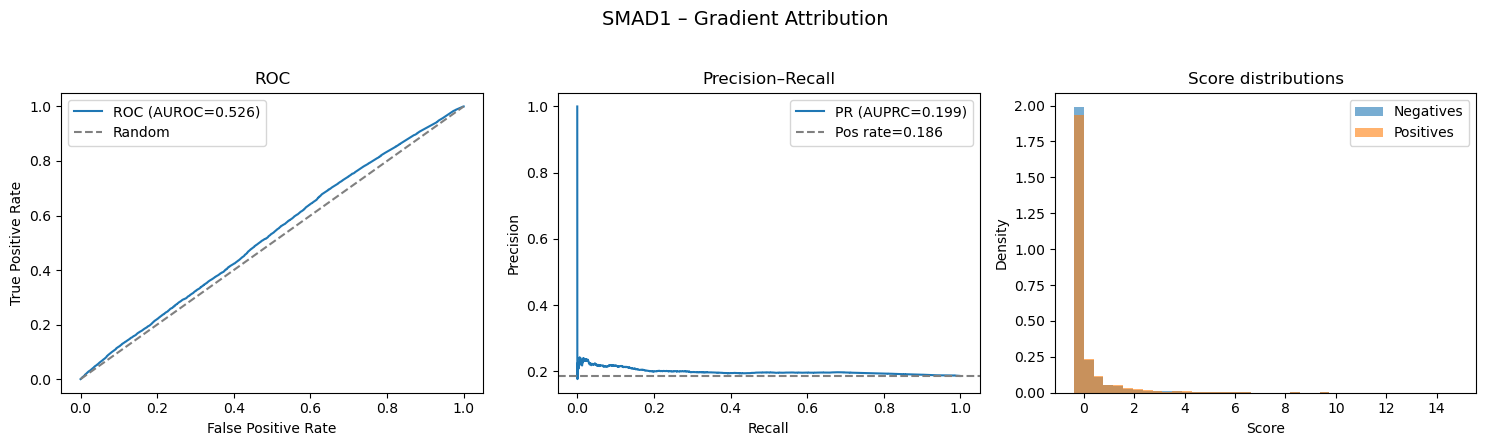


=== TF: MBD2 (Gradient Attribution) ===
Total edges: 6041, positives: 4, negatives: 6037
Per-TF AUROC: 0.443, AUPRC: 0.001


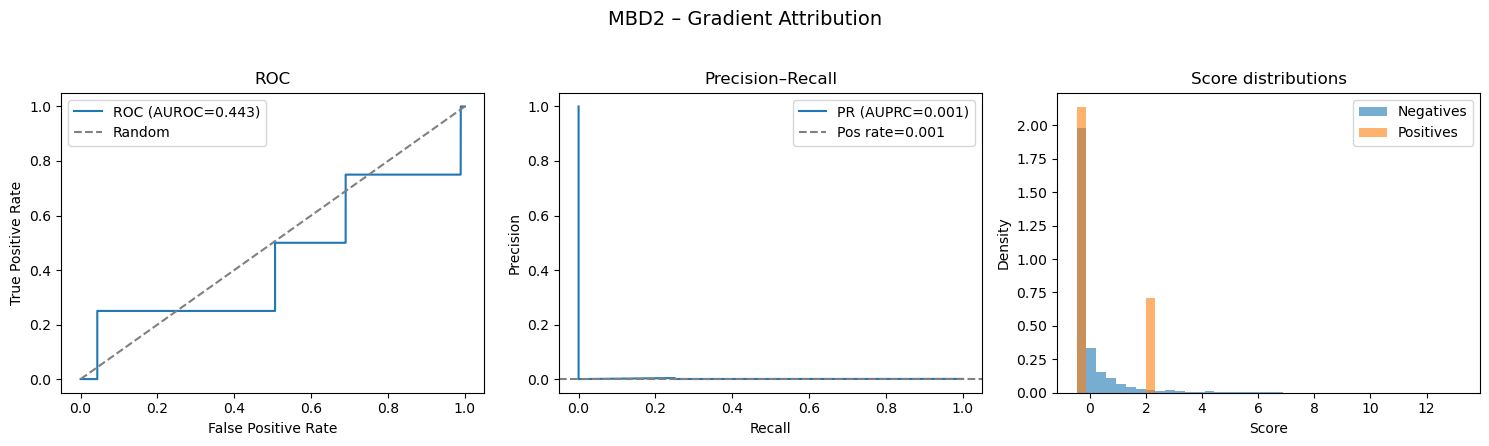


=== TF: JUN (Gradient Attribution) ===
Total edges: 6041, positives: 34, negatives: 6007
Per-TF AUROC: 0.437, AUPRC: 0.005


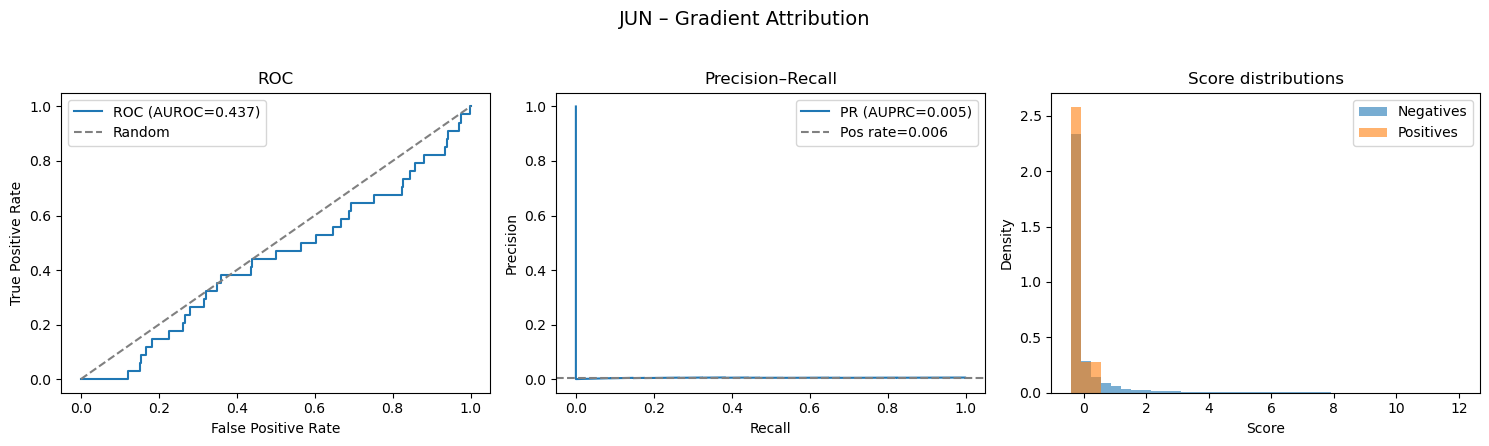

In [202]:
all_edges_labeled = []

for gt_name, ground_truth_df in ground_truth_df_dict.items():
    print(f"Labeling Gradient Attribution edges for {gt_name}...")
        
    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names) &
        ground_truth_df["Target"].isin(tg_names)
    ]
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs = set(chip_valid["Source"])
    gt_tgs = set(chip_valid["Target"])
    
    # Only do Gradient Attribution here
    method_df = gradient_attrib_df
    
    # Filter to THIS GT's gene set
    filtered_df = auroc_testing.filter_df_to_gene_set(
        method_df.copy(),
        gt_tfs,
        gt_tgs,
    )
    
    # Label edges for THIS GT
    labeled_df = auroc_testing.label_edges(filtered_df, gt_edges)
    # labeled_df now has 'Source','Target','Score','is_gt' (plus anything else your function adds)
    
    # Add metadata columns
    labeled_df["method"] = "Gradient Attribution"
    labeled_df["gt_name"] = gt_name
    
    # For convenience, standardize column names
    labeled_df = labeled_df.rename(
        columns={"Source": "tf", "Target": "tg", "Score": "score", "is_gt": "label"}
    )
    
    all_edges_labeled.append(labeled_df)

edge_df = pd.concat(all_edges_labeled, ignore_index=True)

# loop over the worst TFs:
for tf in ["SMAD1", "MBD2", "JUN"]:
    inspect_tf(edge_df, tf, method="Gradient Attribution")  # all GTs combined


In [203]:
# ground_truth_df: columns ['Source','Target']
tf_pos_counts = (
    ground_truth_df
    .groupby("Source")["Target"]
    .nunique()
    .rename("n_pos")
)

# merge with your tf_stats if you like
tf_info = tf_stats.join(tf_pos_counts, how="left").fillna({"n_pos": 0})

# filter for evaluation
MIN_POS = 20  # or 10/30 depending on how strict you want
good_tfs = tf_info.index[tf_info["n_pos"] >= MIN_POS]

# later, when computing per-TF metrics:
per_tf_metrics_filtered = per_tf_metrics[per_tf_metrics["tf"].isin(good_tfs)]


In [204]:
import pandas as pd
import numpy as np

def summarize_tfs(per_tf_metrics, method="Gradient Attribution"):
    """
    Collapse per_tf_metrics -> one row per TF for a given method.
    Assumes columns: ['method','tf','auroc','n_edges','n_pos'] at least.
    """
    df = per_tf_metrics[per_tf_metrics["method"] == method].copy()
    
    tf_summary = (
        df.groupby("tf")
          .agg(
              mean_auroc=("auroc", "mean"),
              std_auroc=("auroc", "std"),
              n_edges=("n_edges", "sum"),
              n_pos=("n_pos", "sum"),
          )
    )

    # Macro per-TF AUROC (each TF equal weight)
    macro_auroc = tf_summary["mean_auroc"].mean()

    # Micro per-TF AUROC (weight by #edges)
    weights = tf_summary["n_edges"]
    micro_auroc = (tf_summary["mean_auroc"] * weights).sum() / weights.sum()

    return tf_summary, macro_auroc, micro_auroc

def evaluate_tf_filters(
    per_tf_metrics,
    method="Gradient Attribution",
    min_pos_list=(0, 1, 5, 10, 20, 50),
    min_edges_list=(0, ),
):
    tf_summary, macro_all, micro_all = summarize_tfs(per_tf_metrics, method=method)
    
    total_tfs = len(tf_summary)
    total_pos = tf_summary["n_pos"].sum()
    total_edges = tf_summary["n_edges"].sum()
    
    results = []

    for min_pos in min_pos_list:
        for min_edges in min_edges_list:
            mask = (tf_summary["n_pos"] >= min_pos) & (tf_summary["n_edges"] >= min_edges)
            tf_sub = tf_summary[mask]
            if tf_sub.empty:
                continue

            macro = tf_sub["mean_auroc"].mean()
            micro = (tf_sub["mean_auroc"] * tf_sub["n_edges"]).sum() / tf_sub["n_edges"].sum()

            results.append({
                "method": method,
                "min_pos": min_pos,
                "min_edges": min_edges,
                "n_tfs_kept": len(tf_sub),
                "frac_tfs_kept": len(tf_sub) / total_tfs,
                "frac_pos_covered": tf_sub["n_pos"].sum() / total_pos,
                "frac_edges_covered": tf_sub["n_edges"].sum() / total_edges,
                "macro_auroc_filtered": macro,
                "micro_auroc_filtered": micro,
                "macro_auroc_all": macro_all,
                "micro_auroc_all": micro_all,
            })

    results_df = pd.DataFrame(results).sort_values(
        ["macro_auroc_filtered"], ascending=False
    )

    return tf_summary, results_df


In [205]:
tf_summary, filter_results = evaluate_tf_filters(
    per_tf_metrics,
    method="Gradient Attribution",
    min_pos_list=(0, 1, 5, 10, 20, 50),
    min_edges_list=(0, 5000, 10000),
)

print(filter_results.head(20))


                  method  min_pos  min_edges  n_tfs_kept  frac_tfs_kept  \
16  Gradient Attribution       50       5000          83       0.943182   
15  Gradient Attribution       50          0          83       0.943182   
7   Gradient Attribution        5       5000          86       0.977273   
6   Gradient Attribution        5          0          86       0.977273   
12  Gradient Attribution       20          0          85       0.965909   
10  Gradient Attribution       10       5000          85       0.965909   
9   Gradient Attribution       10          0          85       0.965909   
13  Gradient Attribution       20       5000          85       0.965909   
1   Gradient Attribution        0       5000          88       1.000000   
0   Gradient Attribution        0          0          88       1.000000   
3   Gradient Attribution        1          0          88       1.000000   
4   Gradient Attribution        1       5000          88       1.000000   
2   Gradient Attribution 

        mean_auroc  n_pos  n_edges  effect_size_d
tf                                               
AEBP2     0.610233   3299     6041       0.178999
ARID3A    0.558727    205     6041       0.099389
ASCL2     0.524862   2644     8798       0.040221
CDX2      0.643713    649    17169       0.316560
E2F1      0.575461   2978    10482       0.095954


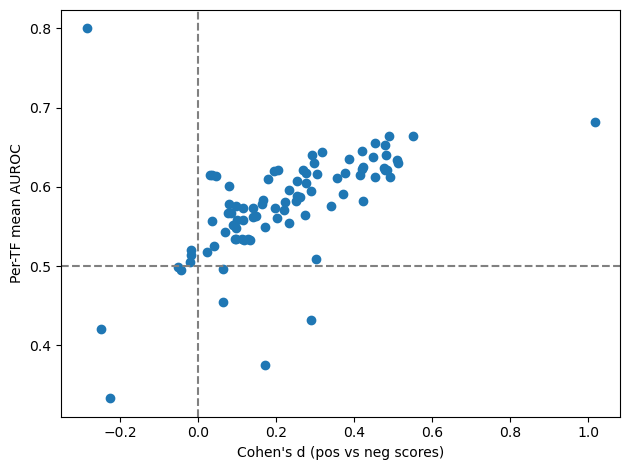

In [206]:
def compute_tf_effect_sizes(edge_df, method="Gradient Attribution"):
    rows = []
    df = edge_df[edge_df["method"] == method]

    for tf, g in df.groupby("tf"):
        y = g["label"].values
        s = g["score"].values

        n_pos = int(y.sum())
        n_neg = len(y) - n_pos
        if n_pos == 0 or n_neg == 0:
            continue

        pos_scores = s[y == 1]
        neg_scores = s[y == 0]

        mu_pos = pos_scores.mean()
        mu_neg = neg_scores.mean()
        var_pos = pos_scores.var(ddof=1)
        var_neg = neg_scores.var(ddof=1)

        # pooled std
        pooled_var = ((n_pos - 1) * var_pos + (n_neg - 1) * var_neg) / (n_pos + n_neg - 2)
        pooled_std = np.sqrt(max(pooled_var, 1e-8))

        d = (mu_pos - mu_neg) / pooled_std

        rows.append({
            "tf": tf,
            "n_edges": len(g),
            "n_pos": n_pos,
            "effect_size_d": d,
        })

    return pd.DataFrame(rows)

effect_df = compute_tf_effect_sizes(edge_df, method="Gradient Attribution")
tf_summary2 = tf_summary.join(
    effect_df.set_index("tf")[["effect_size_d"]],
    how="left"
)

print(tf_summary2[["mean_auroc", "n_pos", "n_edges", "effect_size_d"]].head())
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(tf_summary2["effect_size_d"], tf_summary2["mean_auroc"])
ax.set_xlabel("Cohen's d (pos vs neg scores)")
ax.set_ylabel("Per-TF mean AUROC")
ax.axhline(0.5, color="grey", linestyle="--")
ax.axvline(0.0, color="grey", linestyle="--")
plt.tight_layout()
plt.show()

In [207]:
# 1) Average across TFs within each (method, ground truth)
method_gt_avg = (
    per_tf_metrics
    .groupby(['method', 'gt_name'], as_index=False)
    .agg(
        auroc=('auroc', 'mean'),
        auprc=('auprc', 'mean'),
        n_tfs=('tf', 'nunique'),
    )
)

print("\n=== Per-TF AUROC by Method and Ground Truth ===")
print(method_gt_avg.pivot(index='method', columns='gt_name', values='auroc').round(3))

# 2) Average across ground truths for each method
method_rank_per_tf = (
    method_gt_avg
    .groupby('method')
    .agg(
        mean_auroc=('auroc', 'mean'),
        std_auroc=('auroc', 'std'),
        mean_auprc=('auprc', 'mean'),
        std_auprc=('auprc', 'std'),
        n_gt=('gt_name', 'nunique'),
    )
    .sort_values('mean_auroc', ascending=False)
)

print("\n=== Method Ranking by Per-TF AUROC ===")
print(method_rank_per_tf)

method_rank_per_tf.to_csv("method_ranking_per_tf.csv")


=== Per-TF AUROC by Method and Ground Truth ===
gt_name               ChIP-Atlas  RN111  RN112  RN114  RN115  RN116
method                                                             
Gradient Attribution       0.605  0.557  0.535  0.564  0.535  0.549
TF Knockout                0.562  0.520  0.520  0.537  0.520  0.511

=== Method Ranking by Per-TF AUROC ===
                      mean_auroc  std_auroc  mean_auprc  std_auprc  n_gt
method                                                                  
Gradient Attribution     0.55730   0.026027    0.567789   0.028969     6
TF Knockout              0.52839   0.018365    0.549582   0.019066     6


In [208]:
# 1) Per-dataset summary
dataset_summary = (
    per_tf_metrics
    .groupby(['method', 'gt_name'])
    .agg({
        'auroc': ['mean', 'median', 'std', 'min', 'max'],
        'tf': 'count'
    })
    .round(3)
)
dataset_summary.columns = ['_'.join(col).strip('_') for col in dataset_summary.columns]
print("\n=== Per-Dataset Summary ===")
print(dataset_summary)

# 2) Per-TF summary across datasets
tf_summary = (
    per_tf_metrics
    .groupby(['method', 'tf'])
    .agg({
        'auroc': ['mean', 'std'],
        'gt_name': 'count'
    })
    .round(3)
)
tf_summary.columns = ['_'.join(col).strip('_') for col in tf_summary.columns]
tf_summary = tf_summary.reset_index()

# Show top TFs for each method
print("\n=== Top 20 TFs by AUROC ===")
for method in per_tf_metrics['method'].unique():
    print(f"\n{method}:")
    top_tfs = tf_summary[tf_summary['method'] == method].nlargest(20, 'auroc_mean')
    print(top_tfs[['tf', 'auroc_mean', 'auroc_std', 'gt_name_count']].to_string(index=False))
    
# Show bottom TFs for each method
print("\n=== Bottom 20 TFs by AUROC ===")
for method in per_tf_metrics['method'].unique():
    print(f"\n{method}:")
    bottom_tfs = tf_summary[tf_summary['method'] == method].nsmallest(20, 'auroc_mean')
    print(bottom_tfs[['tf', 'auroc_mean', 'auroc_std', 'gt_name_count']].to_string(index=False))


=== Per-Dataset Summary ===
                                 auroc_mean  auroc_median  auroc_std  \
method               gt_name                                           
Gradient Attribution ChIP-Atlas       0.605         0.613      0.040   
                     RN111            0.557         0.562      0.085   
                     RN112            0.535         0.534      0.044   
                     RN114            0.564         0.560      0.072   
                     RN115            0.535         0.534      0.044   
                     RN116            0.549         0.553      0.211   
TF Knockout          ChIP-Atlas       0.562         0.561      0.050   
                     RN111            0.520         0.530      0.091   
                     RN112            0.520         0.515      0.039   
                     RN114            0.537         0.532      0.077   
                     RN115            0.520         0.515      0.039   
                     RN116         

In [209]:
import importlib

importlib.reload(auroc_testing)

<module 'dev.auroc_testing' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/auroc_testing.py'>


Saved boxplots: per_tf_auroc_boxplot.png, per_tf_auprc_boxplot.png


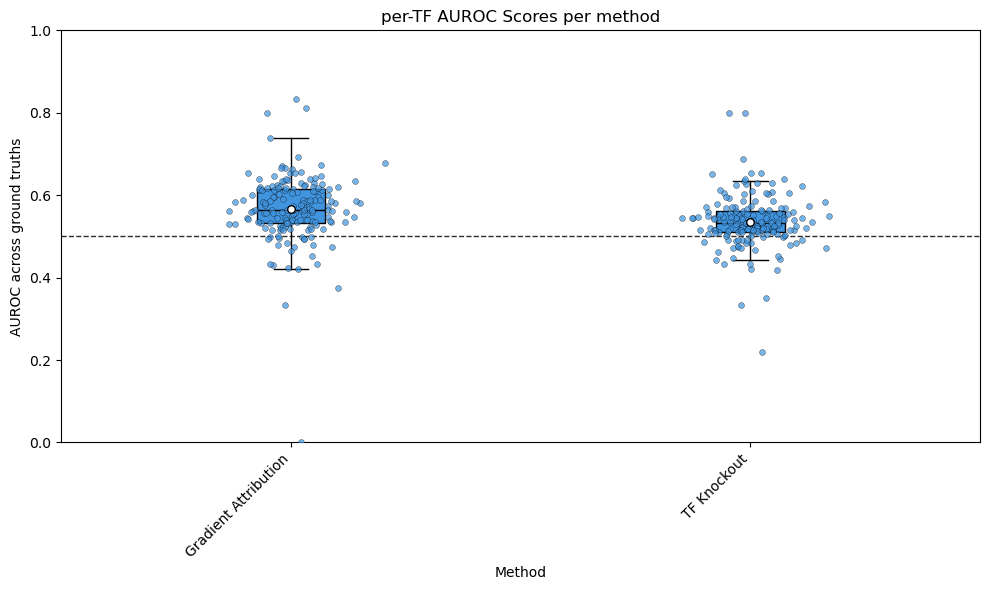

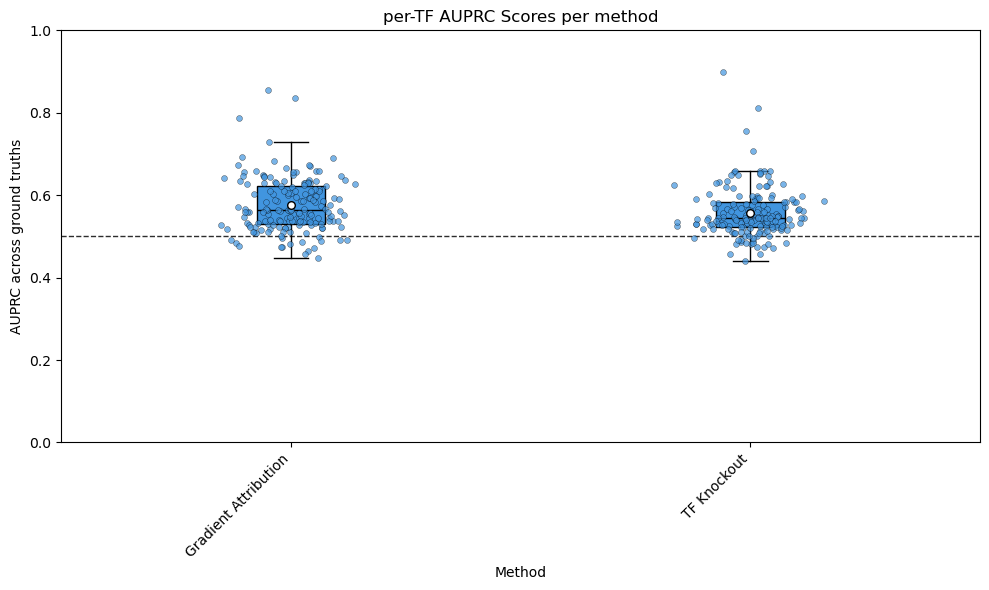

In [210]:
# Format for boxplot functions
per_tf_for_plot = per_tf_metrics[['method', 'auroc', 'auprc']].copy()
per_tf_for_plot = per_tf_for_plot.rename(columns={'method': 'name'})

# Create boxplots
per_tf_auroc_boxplot = auroc_testing.plot_all_results_auroc_boxplot(per_tf_for_plot, per_tf=True)
per_tf_auprc_boxplot = auroc_testing.plot_all_results_auprc_boxplot(per_tf_for_plot, per_tf=True)

per_tf_auroc_boxplot.savefig("per_tf_auroc_boxplot.png", dpi=300, bbox_inches='tight')
per_tf_auprc_boxplot.savefig("per_tf_auprc_boxplot.png", dpi=300, bbox_inches='tight')

print("\nSaved boxplots: per_tf_auroc_boxplot.png, per_tf_auprc_boxplot.png")

In [211]:
# Create comparison table
comparison = pd.DataFrame({
    'method': method_rank['name'] if 'name' in method_rank.columns else method_rank.index,
    'pooled_auroc': method_rank['mean_auroc'].values,
    'per_tf_auroc': method_rank_per_tf.loc[method_rank.index, 'mean_auroc'].values,
})
comparison['difference'] = comparison['per_tf_auroc'] - comparison['pooled_auroc']

print("\n=== Pooled vs Per-TF AUROC Comparison ===")
print(comparison)


=== Pooled vs Per-TF AUROC Comparison ===
                 method  pooled_auroc  per_tf_auroc  difference
0  Gradient Attribution      0.536336       0.55730    0.020965
1           TF Knockout      0.528736       0.52839   -0.000346


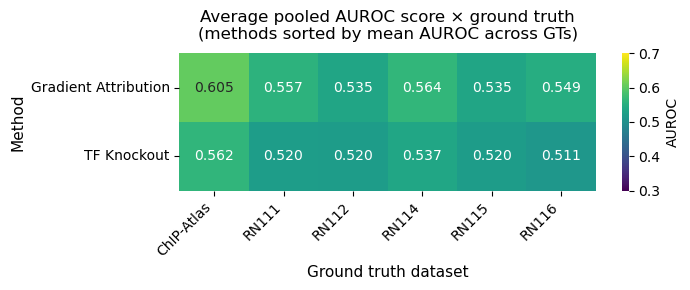

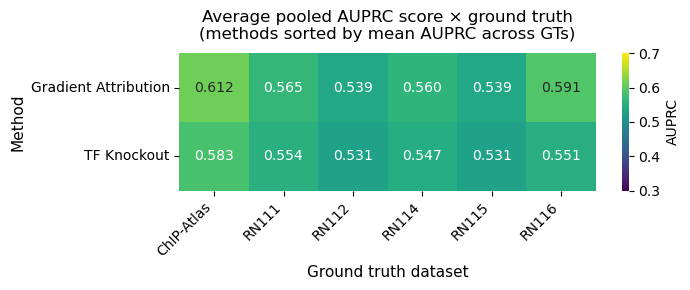

In [212]:
# Prepare data for heatmap (needs 'name' column instead of 'method')
per_tf_heatmap_data = method_gt_avg.copy()
per_tf_heatmap_data = per_tf_heatmap_data.rename(columns={'method': 'name'})
per_tf_heatmap_data['sample'] = 'PER_TF'

# Create AUROC heatmap
per_tf_auroc_heatmap = auroc_testing.plot_method_gt_heatmap(
    per_tf_heatmap_data, 
    metric="auroc"
)
per_tf_auroc_heatmap.show()

# Create AUPRC heatmap
per_tf_auprc_heatmap = auroc_testing.plot_method_gt_heatmap(
    per_tf_heatmap_data, 
    metric="auprc"
)

per_tf_auprc_heatmap.show()


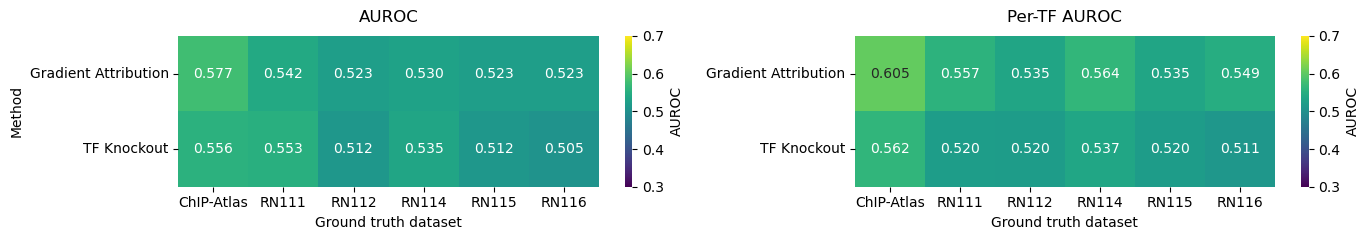

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pooled_vs_per_tf_comparison(df_pooled, per_tf_heatmap_data, metric="auroc"):
    """Create side-by-side heatmaps comparing pooled vs per-TF metrics."""
    
    metric = metric.lower()
    
    # Get method order (by per-TF mean)
    method_order = (
        per_tf_heatmap_data.groupby("name")[metric]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    
    # Pivot both datasets
    pooled_heat = df_pooled.pivot_table(
        index="name", columns="gt_name", values=metric
    ).loc[method_order]
    
    per_tf_heat = per_tf_heatmap_data.pivot_table(
        index="name", columns="gt_name", values=metric
    ).loc[method_order]
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 2.5))
    
    # Pooled heatmap
    sns.heatmap(
        pooled_heat,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        vmin=0.3,
        vmax=0.7,
        cbar_kws={"label": metric.upper()},
        ax=ax1,
    )
    ax1.set_title(f"{metric.upper()}", fontsize=12, pad=10)
    ax1.set_xlabel("Ground truth dataset", fontsize=10)
    ax1.set_ylabel("Method", fontsize=10)
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

    
    # Per-TF heatmap
    sns.heatmap(
        per_tf_heat,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        vmin=0.3,
        vmax=0.7,
        cbar_kws={"label": metric.upper()},
        ax=ax2,
    )
    ax2.set_title(f"Per-TF {metric.upper()}", fontsize=12, pad=10)
    ax2.set_xlabel("Ground truth dataset", fontsize=10)
    ax2.set_ylabel("")
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    return fig

# Create comparison
comparison_fig = plot_pooled_vs_per_tf_comparison(
    df_results,  # pooled results
    per_tf_heatmap_data,  # per-TF results
    metric="auroc"
)
comparison_fig.show()

## Filtering by TG Prediction confidence

In [214]:
importlib.reload(auroc_testing)

<module 'dev.auroc_testing' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/auroc_testing.py'>

### Load Model and run test set TG expression predictions

Evaluating on test set: 100%|████████████| 447/447 [00:25<00:00, 17.37batches/s]


Per-gene R² stats (ignoring NaNs / near-constant genes):
  mean   : 0.6929864866077553
  median : 0.7973034432926742
  std    : 0.37358681168650426

SCATTER PLOT STATISTICS
Overall R² (from all points): 0.8903
N samples (valid points): 2,583,600
Prediction range: [0.0000, 5.4410]
Target range:     [-0.0000, 5.2481]
Median per-gene R²: 0.7973


/tmp/ipykernel_1379925/1982338861.py:173: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


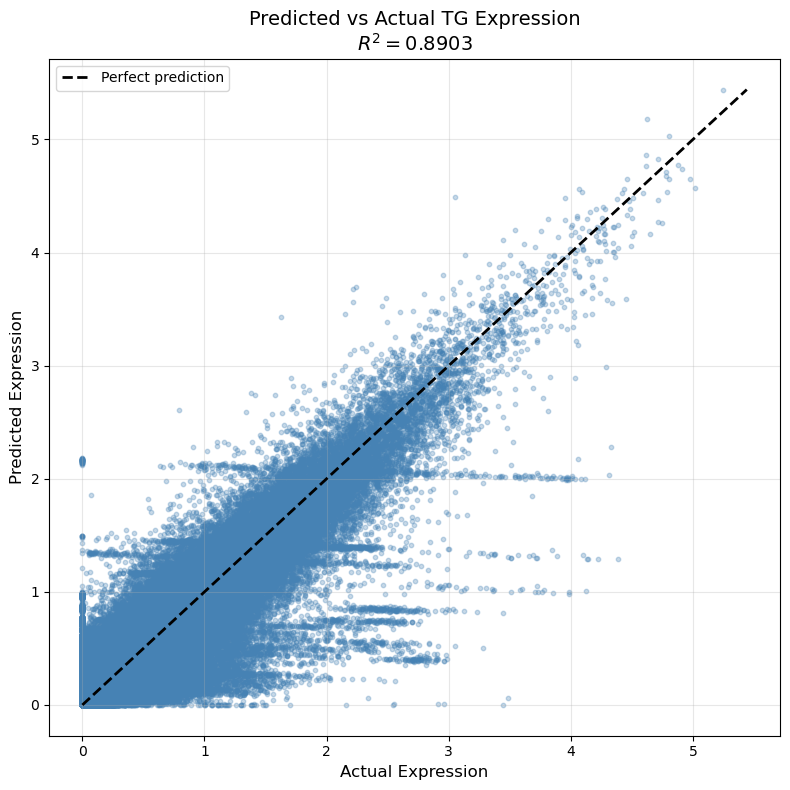

In [216]:
from sklearn.metrics import r2_score

checkpoint_file = "checkpoint_195.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, test_loader, tg_scaler, tf_scaler, state = auroc_testing.load_model(base_model_dir, checkpoint_file, device)

G_total = len(state["tg_scaler_mean"])

tg_sse  = torch.zeros(G_total, device="cpu", dtype=torch.float32)  # sum of squared errors
tg_sum  = torch.zeros(G_total, device="cpu", dtype=torch.float32)  # sum of y
tg_sum2 = torch.zeros(G_total, device="cpu", dtype=torch.float32)  # sum of y^2
tg_n    = torch.zeros(G_total, device="cpu", dtype=torch.float32)  # count

num_batches = len(test_loader)

model.to(device).eval()

G_total = tg_scaler.mean.shape[0]  # total number of genes

# ---- global per-gene accumulators (unscaled space) ----
sse_g   = torch.zeros(G_total, dtype=torch.float64)
sumy_g  = torch.zeros(G_total, dtype=torch.float64)
sumy2_g = torch.zeros(G_total, dtype=torch.float64)
cnt_g   = torch.zeros(G_total, dtype=torch.float64)

### For overall R² and scatter:
all_preds_for_plot = []
all_tgts_for_plot  = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating on test set", unit="batches", ncols=80)):
        atac_wins, tf_tensor, targets, bias, tf_ids, tg_ids, motif_mask = batch
        atac_wins  = atac_wins.to(device)
        tf_tensor  = tf_tensor.to(device)
        targets    = targets.to(device)
        bias       = bias.to(device)
        tf_ids     = tf_ids.to(device)
        tg_ids     = tg_ids.to(device)
        motif_mask = motif_mask.to(device)

        # scale / predict exactly like in validation
        if tf_scaler is not None:
            tf_tensor = tf_scaler.transform(tf_tensor, tf_ids)
        if tg_scaler is not None:
            targets_s = tg_scaler.transform(targets, tg_ids)
        else:
            targets_s = targets

        preds_s, _, _, _ = model(
            atac_wins, tf_tensor,
            tf_ids=tf_ids, tg_ids=tg_ids,
            bias=bias, motif_mask=motif_mask,
            return_edge_logits=True, return_shortcut_contrib=False,
            edge_extra_features=None,
        )

        preds_s   = torch.nan_to_num(preds_s.float(),   nan=0.0, posinf=1e6, neginf=-1e6)
        targets_s = torch.nan_to_num(targets_s.float(), nan=0.0, posinf=1e6, neginf=-1e6)

        # unscale + clamp
        if tg_scaler is not None:
            targets_u = tg_scaler.inverse_transform(targets_s, tg_ids)
            preds_u   = tg_scaler.inverse_transform(preds_s,   tg_ids)
        else:
            targets_u, preds_u = targets_s, preds_s

        targets_u = torch.nan_to_num(targets_u.float(), nan=0.0, posinf=1e6, neginf=-1e6)
        preds_u   = torch.nan_to_num(preds_u.float(),   nan=0.0, posinf=1e6, neginf=-1e6)
        preds_u   = preds_u.clamp_min(0.0)

        # ---- store for overall R² / scatter ----
        all_tgts_for_plot.append(targets_u.detach().cpu().numpy())
        all_preds_for_plot.append(preds_u.detach().cpu().numpy())

        # ---- per-gene accumulators (unscaled) ----
        # shapes: [B, G_eval]
        err2   = (targets_u - preds_u) ** 2
        B      = targets_u.shape[0]

        # reduce over batch
        sse_batch   = err2.sum(dim=0)              # [G_eval]
        sumy_batch  = targets_u.sum(dim=0)
        sumy2_batch = (targets_u ** 2).sum(dim=0)
        cnt_batch   = torch.full_like(sse_batch, B, dtype=torch.float64)

        # move ids to CPU, accumulate into global vectors
        ids_cpu = tg_ids.cpu()
        sse_g.index_add_(0, ids_cpu, sse_batch.cpu().to(torch.float64))
        sumy_g.index_add_(0, ids_cpu, sumy_batch.cpu().to(torch.float64))
        sumy2_g.index_add_(0, ids_cpu, sumy2_batch.cpu().to(torch.float64))
        cnt_g.index_add_(0, ids_cpu, cnt_batch.cpu().to(torch.float64))

# ============================
# 4) Per-gene R² (global)
# ============================
eps = 1e-12
mask = cnt_g > 0  # genes that appeared in the test set

mean_g = sumy_g[mask] / cnt_g[mask]
sst_g  = sumy2_g[mask] - cnt_g[mask] * (mean_g ** 2)

valid = sst_g > eps  # genes with non-trivial variance

r2_g = torch.full_like(sse_g, float("nan"), dtype=torch.float64)

idx_all  = mask.nonzero(as_tuple=True)[0]   # indices of genes with any data
idx_keep = idx_all[valid]                   # subset with non-zero variance

r2_g_values = 1.0 - (sse_g[idx_keep] / torch.clamp(sst_g[valid], min=eps))
r2_g[idx_keep] = r2_g_values

r2_g_cpu = r2_g.cpu().numpy()
mean_r2_gene   = np.nanmean(r2_g_cpu)
median_r2_gene = np.nanmedian(r2_g_cpu)
std_r2_gene    = np.nanstd(r2_g_cpu)



print("Per-gene R² stats (ignoring NaNs / near-constant genes):")
print("  mean   :", mean_r2_gene)
print("  median :", median_r2_gene)
print("  std    :", std_r2_gene)

# ============================
# 5) Global R² + scatter plot
# ============================
preds_flat = np.concatenate([p.reshape(-1) for p in all_preds_for_plot])
tgts_flat  = np.concatenate([t.reshape(-1) for t in all_tgts_for_plot])

# Remove NaNs / infs
valid = np.isfinite(preds_flat) & np.isfinite(tgts_flat)
preds_clean = preds_flat[valid]
tgts_clean  = tgts_flat[valid]

# Overall R² across all points
r2_overall = r2_score(tgts_clean, preds_clean)

print("\n" + "="*60)
print("SCATTER PLOT STATISTICS")
print("="*60)
print(f"Overall R² (from all points): {r2_overall:.4f}")
print(f"N samples (valid points): {len(preds_clean):,}")
print(f"Prediction range: [{np.min(preds_clean):.4f}, {np.max(preds_clean):.4f}]")
print(f"Target range:     [{np.min(tgts_clean):.4f}, {np.max(tgts_clean):.4f}]")
print(f"Median per-gene R²: {median_r2_gene:.4f}")

# ---- scatter plot ----
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tgts_clean, preds_clean, alpha=0.3, s=10, color='steelblue')

lims = [
    min(np.min(tgts_clean), np.min(preds_clean)),
    max(np.max(tgts_clean), np.max(preds_clean))
]
ax.plot(lims, lims, 'k--', lw=2, label='Perfect prediction')

ax.set_xlabel('Actual Expression', fontsize=12)
ax.set_ylabel('Predicted Expression', fontsize=12)
ax.set_title(
    "Predicted vs Actual TG Expression\n"
    f"$R^2 = {r2_overall:.4f}$",
    fontsize=14,
)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# `tg_names` should be your vocabulary list in the same order as tg_scaler.mean
assert len(tg_names) == G_total

# counts per TG on CPU
cnt_cpu = cnt_g.cpu().numpy()

# Build a per-TG R² dataframe
per_tg_r2_df = pd.DataFrame({
    "tg_idx": np.arange(G_total),
    "tg": tg_names,
    "r2": r2_g_cpu,
    "n_samples": cnt_cpu,
})

# Keep only genes that actually appeared and had variance (same mask as before)
per_tg_r2_valid = per_tg_r2_df[~np.isnan(per_tg_r2_df["r2"])].copy()

# Sort by R² if you like
per_tg_r2_valid = per_tg_r2_valid.sort_values("r2", ascending=False)

print(per_tg_r2_valid.head())
print(per_tg_r2_valid.tail())



      tg_idx      tg        r2  n_samples
5137    5137   RPL30  0.995146      554.0
5174    5174  RPS27A  0.994820      554.0
2974    2974  IFI213  0.994761      576.0
2970    2970  IFI204  0.994732      576.0
5164    5164  RPS15A  0.994611      554.0
      tg_idx       tg          r2  n_samples
3136    3136    ITGB2   -4.565657      576.0
5664    5664    SNX20   -5.784976      544.0
5580    5580   SLC9A3   -9.730126      576.0
2511    2511  GM15987  -12.833742      576.0
3774    3774    MPEG1 -987.386064      554.0


### Filter Edges by TG Prediction R2

In [ ]:
from sklearn.preprocessing import minmax_scale

# Attach raw r2 to each GA edge
grad_attrib_with_r2 = (
    gradient_attrib_df
    .merge(
        per_tg_r2_valid[["tg", "r2"]],
        how="left",
        left_on="Target",
        right_on="tg",
    )
    .drop(columns=["tg"])  # we already have Target
    .rename(columns={"r2": "tg_r2"})
)

grad_attrib_with_r2 = grad_attrib_with_r2.dropna(subset=["tg_r2"])

grad_attrib_with_r2["Score_scaled"] = minmax_scale(grad_attrib_with_r2["Score"])
grad_attrib_with_r2["tg_r2_scaled"] = minmax_scale(grad_attrib_with_r2["tg_r2"])


In [ ]:
def evaluate_min_tg_r2_filters(
    base_edges_df,
    ground_truth_df_dict,
    tf_names,
    tg_names,
    min_r2_grid=None,
    min_edges=10,
    min_pos=1,
):
    """
    base_edges_df: DataFrame with at least ['Source','Target','Score','tg_r2']
    Returns
    -------
    results_df : DataFrame with per-threshold metrics
    baseline_macro : float, macro AUROC with NO TG R² filtering
    """

    if min_r2_grid is None:
        min_r2_grid = [-0.5, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

    total_edges_all = len(base_edges_df)
    total_tgs_all   = base_edges_df["Target"].nunique()

    results = []

    # -------------------------------------------------------
    # Helper: compute macro/micro AUROC for a given edge DF
    # -------------------------------------------------------
    def compute_macro_micro(edges_df):
        method_dict_base = {"Gradient Attribution": edges_df}
        per_tf_all_results = []

        for gt_name, ground_truth_df in ground_truth_df_dict.items():
            chip_valid = ground_truth_df[
                ground_truth_df["Source"].isin(tf_names)
                & ground_truth_df["Target"].isin(tg_names)
            ]
            gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
            gt_tfs   = set(chip_valid["Source"])
            gt_tgs   = set(chip_valid["Target"])

            for method_name, method_df in method_dict_base.items():
                filtered_df = auroc_testing.filter_df_to_gene_set(
                    method_df.copy(), gt_tfs, gt_tgs
                )
                labeled_df = auroc_testing.label_edges(filtered_df, gt_edges)

                per_tf_df = auroc_testing.compute_per_tf_metrics(
                    labeled_df,
                    score_col="Score",
                    label_col="is_gt",
                    tf_col="Source",
                    min_edges=min_edges,
                    min_pos=min_pos,
                    balance=True,
                )

                if per_tf_df.empty:
                    # nothing for this GT
                    continue

                per_tf_df["method"]  = method_name
                per_tf_df["gt_name"] = gt_name
                per_tf_all_results.append(per_tf_df)

        if not per_tf_all_results:
            return np.nan, np.nan

        per_tf_metrics = pd.concat(per_tf_all_results, ignore_index=True)
        df = per_tf_metrics.query("method == 'Gradient Attribution'")

        macro_auroc = df.groupby("tf")["auroc"].mean().mean()
        micro_auroc = (
            df.groupby("tf")
              .apply(lambda g: g["auroc"].mean() * g["n_edges"].sum(), include_groups=False)
              .sum() / df["n_edges"].sum()
        )
        return macro_auroc, micro_auroc

    # ---------------------------
    # 1) Baseline (no R² filter)
    # ---------------------------
    baseline_macro, baseline_micro = compute_macro_micro(base_edges_df)
    print(
        f"Baseline (no TG R² filter) macro/micro AUROC: "
        f"{baseline_macro:.3f} / {baseline_micro:.3f}"
    )

    # ---------------------------
    # 2) R²-threshold sweeps
    # ---------------------------
    for min_r2 in min_r2_grid:
        print(f"\n=== Evaluating min_tg_r2 >= {min_r2:.2f} ===")

        # Filter by TG R²
        edges_filt = base_edges_df[base_edges_df["tg_r2"] >= min_r2].copy()
        n_edges_filt = len(edges_filt)
        n_tgs_filt   = edges_filt["Target"].nunique()

        if n_edges_filt == 0:
            print("  No edges left after filtering; skipping this threshold.")
            continue

        macro_auroc, micro_auroc = compute_macro_micro(edges_filt)
        print(f"  Macro / micro AUROC: {macro_auroc:.3f} / {micro_auroc:.3f}")

        results.append({
            "min_tg_r2": min_r2,
            "n_edges_kept": n_edges_filt,
            "frac_edges_kept": n_edges_filt / total_edges_all,
            "n_tgs_kept": n_tgs_filt,
            "frac_tgs_kept": n_tgs_filt / total_tgs_all,
            "macro_auroc": macro_auroc,
            "micro_auroc": micro_auroc,
        })

    results_df = pd.DataFrame(results).sort_values("min_tg_r2")
    return results_df, baseline_macro, baseline_micro


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


Baseline (no TG R² filter) macro/micro AUROC: 0.578 / 0.577

=== Evaluating min_tg_r2 >= -1.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.574 / 0.579

=== Evaluating min_tg_r2 >= -0.50 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.588 / 0.585

=== Evaluating min_tg_r2 >= 0.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.580 / 0.578

=== Evaluating min_tg_r2 >= 0.10 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.580 / 0.577

=== Evaluating min_tg_r2 >= 0.20 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.575 / 0.575

=== Evaluating min_tg_r2 >= 0.30 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.580 / 0.576

=== Evaluating min_tg_r2 >= 0.40 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.587 / 0.582

=== Evaluating min_tg_r2 >= 0.50 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.591 / 0.584

=== Evaluating min_tg_r2 >= 0.60 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.585 / 0.578

=== Evaluating min_tg_r2 >= 0.70 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.596 / 0.585

=== Evaluating min_tg_r2 >= 0.80 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.584 / 0.577

=== Evaluating min_tg_r2 >= 0.90 ===
  Macro / micro AUROC: 0.571 / 0.566


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


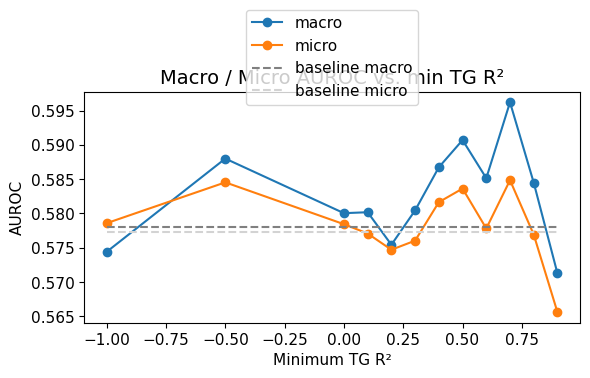

In [ ]:
min_r2_grid = [-1.0, -0.5, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_r2, baseline_macro, baseline_micro = evaluate_min_tg_r2_filters(
    base_edges_df=grad_attrib_with_r2,
    ground_truth_df_dict=ground_truth_df_dict,
    tf_names=tf_names,
    tg_names=tg_names,
    min_r2_grid=min_r2_grid,
    min_edges=10,
    min_pos=1,
)


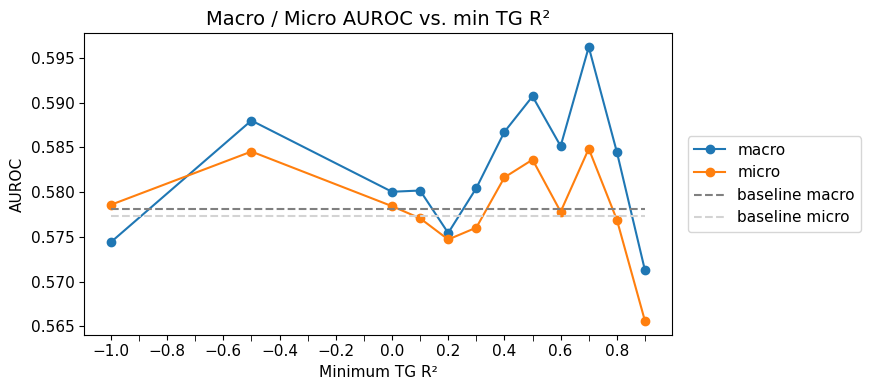

In [ ]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(results_r2["min_tg_r2"], results_r2["macro_auroc"], marker="o", label="macro")
ax.plot(results_r2["min_tg_r2"], results_r2["micro_auroc"], marker="o", label="micro")
ax.hlines(baseline_macro, min_r2_grid[0], min_r2_grid[-1],
          color="grey", linestyle="dashed", label="baseline macro")
ax.hlines(baseline_micro, min_r2_grid[0], min_r2_grid[-1],
          color="lightgrey", linestyle="dashed", label="baseline micro")

ax.set_title("Macro / Micro AUROC vs. min TG R²", fontsize=14)
ax.set_xlabel("Minimum TG R²", fontsize=11)
ax.set_ylabel("AUROC", fontsize=11)

# Major ticks every 0.2
ax.xaxis.set_major_locator(MultipleLocator(0.2))

# One minor tick between each major (every 0.1)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(axis="x", which="major", labelsize=11)
ax.tick_params(axis="y", which="major", labelsize=11)
ax.tick_params(axis="x", which="minor", length=4)  # just the small tick bars, no labels

ax.legend(bbox_to_anchor=(1.175, 0.5), loc="center", fontsize=11)
fig.tight_layout()
plt.savefig(FIG_DIR / "threshold_GA_by_r2.svg")
plt.show()


In [ ]:
print(results_r2[
    ["min_tg_r2", "frac_tgs_kept", "frac_edges_kept", "macro_auroc", "micro_auroc"]
])


   min_tg_r2  frac_tgs_kept  frac_edges_kept  macro_auroc  micro_auroc
0       -0.5       0.995909         0.995909     0.588003     0.584538
1        0.0       0.958656         0.958656     0.580045     0.578441
2        0.1       0.950037         0.950037     0.580184     0.577081
3        0.2       0.927831         0.927831     0.575443     0.574716
4        0.3       0.889701         0.889701     0.580456     0.576040
5        0.4       0.844558         0.844558     0.586737     0.581651
6        0.5       0.791234         0.791234     0.590701     0.583631


### Weight Edges by TG Prediction R2

In [ ]:
import numpy as np

def add_r2_weighted_score(df, r2_col="tg_r2", score_col="Score",
                          clip_min=-2.0, alpha=1.0):
    """
    Create a new column 'Score_weighted' = Score * f(R2).

    - clip_min: R² below this are set to this value (e.g. 0 -> ignore negative R²).
    - alpha: controls how strongly you emphasize high-R² TGs.
    """
    out = df.copy()

    r2 = out[r2_col].to_numpy().astype(float)

    # 1) Clip very low R² (e.g. treat negative R² as 0)
    r2_clipped = np.clip(r2, a_min=clip_min, a_max=None)

    # 2) Normalize to [0, 1] so weights are well-behaved
    r2_min = r2_clipped.min()
    r2_max = r2_clipped.max()
    if r2_max > r2_min:
        r2_norm = (r2_clipped - r2_min) / (r2_max - r2_min)
    else:
        # degenerate case: all equal
        r2_norm = np.ones_like(r2_clipped)

    # 3) Non-linear emphasis: w in (0,1], larger alpha => more emphasis on high-R² TGs
    w = np.power(r2_norm + 1e-8, alpha)

    out["Score_weighted"] = out[score_col].to_numpy() * w
    return out

def add_rank_based_score(df, score_col="Score", r2_col="tg_r2", beta=0.2):
    """
    Combine GA score and TG R² via rank-based convex combination.

    beta in [0,1]:
      - beta=0: pure GA (no R²)
      - beta=1: pure R² ranking
    """
    out = df.copy()

    # Rank-transform GA scores (higher = better)
    score_rank = out[score_col].rank(method="average", pct=True).to_numpy()

    # Rank-transform TG R² across genes; map back to each edge
    tg_r2 = out[[ "Target", r2_col ]].drop_duplicates()
    tg_r2["r2_rank"] = tg_r2[r2_col].rank(method="average", pct=True)
    out = out.merge(
        tg_r2[["Target", "r2_rank"]],
        on="Target",
        how="left"
    )

    r2_rank = out["r2_rank"].to_numpy()

    combo = (1.0 - beta) * score_rank + beta * r2_rank
    out["Score_rank_combo"] = combo

    return out


In [ ]:
grad_attrib_weighted = add_r2_weighted_score(
    grad_attrib_with_r2,
    r2_col="tg_r2",
    score_col="Score",
    clip_min=-2.0,
    alpha=1.0
)

grad_attrib_weighted = add_rank_based_score(
    grad_attrib_weighted,
    r2_col="tg_r2",
    score_col="Score",
    beta=0.2
)

In [ ]:
base_edges_df = grad_attrib_weighted.copy()
base_edges_df["Score"] = base_edges_df["Score_weighted"]

min_r2_grid = [-1.0, -0.5, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_weighted, baseline_macro_w, baseline_micro_w = evaluate_min_tg_r2_filters(
    base_edges_df=base_edges_df,          # <- weights applied
    ground_truth_df_dict=ground_truth_df_dict,
    tf_names=tf_names,
    tg_names=tg_names,
    min_r2_grid=min_r2_grid,
    min_edges=10,
    min_pos=1,
)

print(results_weighted.head())


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


Baseline (no TG R² filter) macro/micro AUROC: 0.565 / 0.569

=== Evaluating min_tg_r2 >= -1.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.560 / 0.566

=== Evaluating min_tg_r2 >= -0.50 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.575 / 0.572

=== Evaluating min_tg_r2 >= 0.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.566 / 0.566

=== Evaluating min_tg_r2 >= 0.10 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.565 / 0.564

=== Evaluating min_tg_r2 >= 0.20 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.572 / 0.569

=== Evaluating min_tg_r2 >= 0.30 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.579 / 0.573

=== Evaluating min_tg_r2 >= 0.40 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.580 / 0.576

=== Evaluating min_tg_r2 >= 0.50 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.581 / 0.577

=== Evaluating min_tg_r2 >= 0.60 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.584 / 0.577

=== Evaluating min_tg_r2 >= 0.70 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.595 / 0.584

=== Evaluating min_tg_r2 >= 0.80 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.583 / 0.576

=== Evaluating min_tg_r2 >= 0.90 ===
  Macro / micro AUROC: 0.570 / 0.565
    min_tg_r2  n_edges_kept  frac_edges_kept  n_tgs_kept  frac_tgs_kept  \
0        -1.0       4361814         0.997224        6826       0.997224   
1        -0.5       4356063         0.995909        6817       0.995909   
2         0.0       4193118         0.958656        6562       0.958656   
3         0.1       4155417         0.950037        6503       0.950037   
4         0.2       4058289         0.927831        6351       0.927831   
5         0.3       3891510         0.889701        6090       0.889701   
6         0.4       3694059         0.844558        5781       0.844558   
7         0.5       3460824         0.791234        5416       0.791234   
8         0.6       3112569         0.711614        4871       0.711614   
9         0.7       2614788         0.597809        4092       0.597809   
10        0.8       1805814         0.412856        2826       

/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


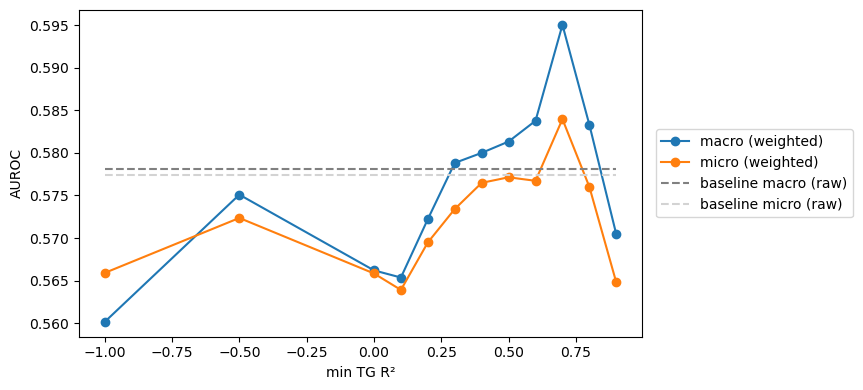

In [ ]:
plt.figure(figsize=(9,4))
plt.plot(results_weighted["min_tg_r2"], results_weighted["macro_auroc"],
         marker="o", label="macro (weighted)")
plt.plot(results_weighted["min_tg_r2"], results_weighted["micro_auroc"],
         marker="o", label="micro (weighted)")

plt.hlines(baseline_macro, min_r2_grid[0], min_r2_grid[-1],
           color="grey", linestyle="dashed", label="baseline macro (raw)")
plt.hlines(baseline_micro, min_r2_grid[0], min_r2_grid[-1],
           color="lightgrey", linestyle="dashed", label="baseline micro (raw)")

plt.title("Macro / Micro AUROC Weighed by TG R²", fontsize=14)
plt.xlabel("min TG R²")
plt.ylabel("AUROC")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center")
plt.tight_layout()
plt.show()


In [ ]:
alphas = [0.0, 0.5, 1.0, 2.0]  # 0.0 = no R² weighting at all
betas = [0.0, 0.1, 0.2, 0.3]

all_results = []
for beta in betas:
    print(f"\n=== beta = {beta} ===")
    # weighted = add_r2_weighted_score(
    #     grad_attrib_with_r2,
    #     r2_col="tg_r2",
    #     score_col="Score",
    #     clip_min=-2.0,
    #     alpha=alpha,
    # )
    weighted = add_rank_based_score(
        grad_attrib_with_r2,
        score_col= "Score",
        r2_col="tg_r2",
        beta=beta,
    )
    tmp_df = weighted.copy()
    tmp_df["Score"] = tmp_df["Score_rank_combo"]

    res, macro0, micro0 = evaluate_min_tg_r2_filters(
        base_edges_df=tmp_df,
        ground_truth_df_dict=ground_truth_df_dict,
        tf_names=tf_names,
        tg_names=tg_names,
        min_r2_grid=[-1.0],   # just “no extra TG filter”, or any grid you like
        min_edges=10,
        min_pos=1,
    )
    res["beta"] = beta
    res["baseline_macro"] = macro0
    res["baseline_micro"] = micro0
    all_results.append(res)

results_alpha = pd.concat(all_results, ignore_index=True)
print(results_alpha)



=== alpha = 2.0 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


Baseline (no TG R² filter) macro/micro AUROC: 0.578 / 0.577

=== Evaluating min_tg_r2 >= -1.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.574 / 0.579

=== alpha = 2.0 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


Baseline (no TG R² filter) macro/micro AUROC: 0.579 / 0.578

=== Evaluating min_tg_r2 >= -1.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.573 / 0.574

=== alpha = 2.0 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


Baseline (no TG R² filter) macro/micro AUROC: 0.577 / 0.576

=== Evaluating min_tg_r2 >= -1.00 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


  Macro / micro AUROC: 0.571 / 0.572

=== alpha = 2.0 ===


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


Baseline (no TG R² filter) macro/micro AUROC: 0.575 / 0.574

=== Evaluating min_tg_r2 >= -1.00 ===
  Macro / micro AUROC: 0.569 / 0.569
   min_tg_r2  n_edges_kept  frac_edges_kept  n_tgs_kept  frac_tgs_kept  \
0       -1.0       4361814         0.997224        6826       0.997224   
1       -1.0       4361814         0.997224        6826       0.997224   
2       -1.0       4361814         0.997224        6826       0.997224   
3       -1.0       4361814         0.997224        6826       0.997224   

   macro_auroc  micro_auroc  beta  baseline_macro  baseline_micro  
0     0.574414     0.578589   0.0        0.578073        0.577361  
1     0.572974     0.573715   0.1        0.578854        0.577848  
2     0.571207     0.571836   0.2        0.577239        0.576226  
3     0.568614     0.569009   0.3        0.574903        0.573553  


/tmp/ipykernel_1379925/2839234346.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tf")


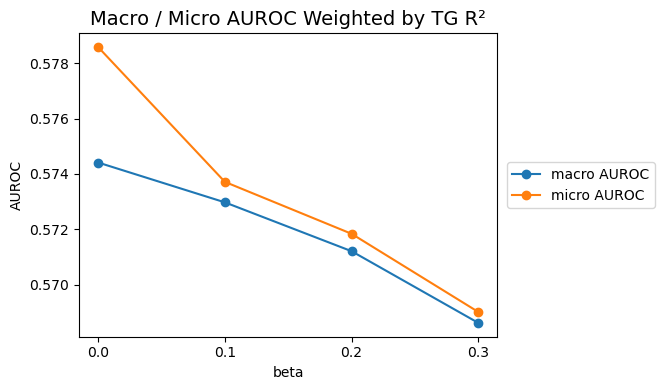

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(results_alpha["beta"], results_alpha["macro_auroc"], marker="o", label="macro AUROC")
plt.plot(results_alpha["beta"], results_alpha["micro_auroc"], marker="o", label="micro AUROC")
plt.xlabel("beta")
plt.ylabel("AUROC")
plt.legend(
    bbox_to_anchor=(1.2, 0.5),
    loc="center",
)
plt.title("Macro / Micro AUROC Weighted by TG R²", fontsize=14)
plt.xticks(betas)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()  

In [ ]:
print(per_tf_metrics.head())

      tf     auroc     auprc  n_edges  n_pos  n_neg                method  \
0   CDX2  0.598673  0.582657     6412    299   6113  Gradient Attribution   
1   EBF1  0.527765  0.524083     6412   2688   3724  Gradient Attribution   
2  EOMES  0.644372  0.658393     6412   1721   4691  Gradient Attribution   
3   FLI1  0.561786  0.540127     6412    494   5918  Gradient Attribution   
4  FOSL2  0.596752  0.605632     6412   4378   2034  Gradient Attribution   

      gt_name  
0  ChIP-Atlas  
1  ChIP-Atlas  
2  ChIP-Atlas  
3  ChIP-Atlas  
4  ChIP-Atlas  


In [ ]:
from sklearn.preprocessing import minmax_scale

per_tg_r2_df = per_tg_r2_df[per_tg_r2_df["r2"] >= -1.0]

grad_attrib_r2_df = pd.merge(
    gradient_attrib_df,
    per_tg_r2_df,
    how="left",
    left_on="Target",
    right_on="tg",)

grad_attrib_r2_df = grad_attrib_r2_df[["Source", "Target", "Score", "r2", "n_samples"]].dropna()
grad_attrib_r2_df["Score"] = minmax_scale(grad_attrib_r2_df["Score"], feature_range=(0.0, 1.0))
grad_attrib_r2_df["r2"] = minmax_scale(grad_attrib_r2_df["r2"], feature_range=(0.0, 1.0))

print(grad_attrib_r2_df.head())

          Source         Target     Score        r2  n_samples
0  2810021J22RIK  0610005C13RIK  0.009341  0.940821      554.0
1  2810021J22RIK  0610009E02RIK  0.004597  0.638575      576.0
2  2810021J22RIK  0610030E20RIK  0.005069  0.851148      576.0
3  2810021J22RIK  1110002J07RIK  0.003780  0.633889      576.0
4  2810021J22RIK  1110019D14RIK  0.013994  0.863181      576.0


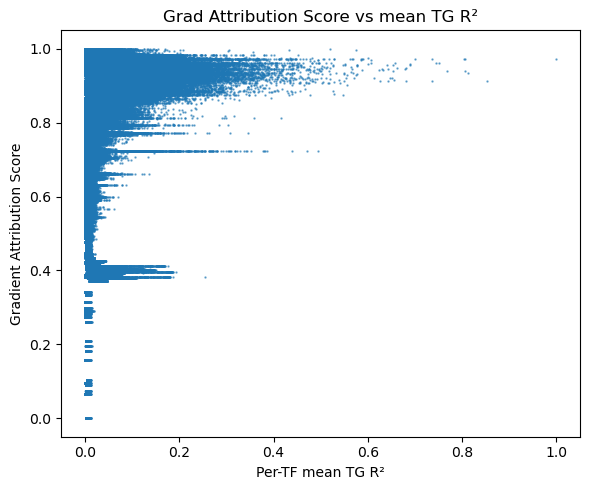

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(grad_attrib_r2_df["Score"], grad_attrib_r2_df["r2"], alpha=0.6, s=0.5)
plt.xlabel("Per-TF mean TG R²")
plt.ylabel("Gradient Attribution Score")
plt.title("Grad Attribution Score vs mean TG R²")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import spearmanr, pearsonr

r_pearson, p_pearson = pearsonr(grad_attrib_r2_df["r2"], grad_attrib_r2_df["Score"])
r_spearman, p_spearman = spearmanr(grad_attrib_r2_df["r2"], grad_attrib_r2_df["Score"])

print(f"Pearson r = {r_pearson:.3f} (p={p_pearson:.3e})")
print(f"Spearman ρ = {r_spearman:.3f} (p={p_spearman:.3e})")


Pearson r = 0.258 (p=0.000e+00)
Spearman ρ = 0.469 (p=0.000e+00)


/tmp/ipykernel_1379925/4245195607.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grad_attrib_r2_df


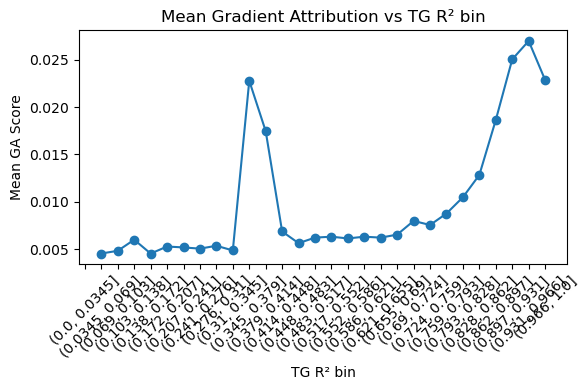

In [ ]:
bins = np.linspace(0, 1, 30)
binned = (
    grad_attrib_r2_df
    .assign(r2_bin=pd.cut(grad_attrib_r2_df["r2"], bins=bins))
    .groupby("r2_bin")["Score"].mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
plt.plot(binned["r2_bin"].astype(str), binned["Score"], marker="o")
plt.xticks(rotation=45)
plt.xlabel("TG R² bin")
plt.ylabel("Mean GA Score")
plt.title("Mean Gradient Attribution vs TG R² bin")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1379925/1517353918.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grad_attrib_r2_df.groupby("Source")


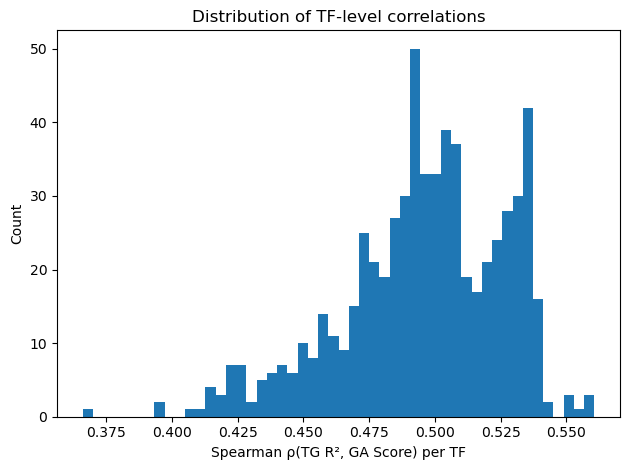

Mean ρ: 0.495386740638419


In [ ]:
tf_corrs = (
    grad_attrib_r2_df.groupby("Source")
    .apply(lambda g: spearmanr(g["r2"], g["Score"]).correlation)
    .dropna()
)

plt.hist(tf_corrs, bins=50)
plt.xlabel("Spearman ρ(TG R², GA Score) per TF")
plt.ylabel("Count")
plt.title("Distribution of TF-level correlations")
plt.tight_layout()
plt.show()

print("Mean ρ:", tf_corrs.mean())
